# DS 325 - Gradient Descent

Linear regression - With so many algorithms to choose from, how do you decide?

In the previous class, we used the normal equation to find the inverse of **$X^T X$** which has dimensions $(n+1)\times(n+1)$.  The number of operations (+,-,*,/) or **computational cost** need to compute this depends on the **dimensions** of the matrix and the **algorithm**.  

* To invert the matrix, the computational cost is $O(n^3)$. 
* The use LinearRegression the cost is $O(n^2)$.  LinearRegression uses SVD (Singular Value Decomposition, $X =  U \Sigma V$, where we have _factored_ $X$ into a scaling $\Sigma$ and eigenvectors $V$)  
* The difference here is significant, with twice the features ($2n$) the computational cost (and time) to invert is 4 times greater than SVD


Gradient descent is an optimization algorithm used to find the values of parameters (coefficients) of a function (f) that minimizes a cost function (cost).

Gradient descent is best used when the parameters cannot be calculated analytically (e.g. using linear algebra) and must be searched for by an optimization algorithm.

### Defining the Cost Function


$$y_{\textrm{pred}} = \boldsymbol{\theta}^{\top}\boldsymbol{x} + b$$
or
$$y_{\textrm{pred}} = \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} + \cdots + \theta_{d} x_{d},$$
where $w_{0} = b$.

* $\mathbf{x} = [x_{1}, x_{2}, \cdots, x_{d}]^{\top}$
* $\mathbf{\theta} = [\theta_{1}, \theta_{2}, \cdots, \theta_{d}]^{\top}$
  
In lecture, we defined the cost function for a linear regression problem using the square loss:

$$J(\theta) = MSE = \frac{1}{n} \sum_{i=1}^n (\theta^T X - y)^2$$

Our linear regression model will look like this:

$$J(\theta) = MSE = \frac{1}{2n} (\theta^T X - y)^T (\theta^T X - y)$$

where the gradient of the cost function is:

$$\nabla J(\theta) =  \frac{2}{n} X^T (\theta^T X - y)$$

To take a step, we subtract the gradient multiplied by the learning rate $\alpha$.

$$\theta_{t+1} =\theta_t + \alpha \nabla J(\theta)$$


## Gradient Descent
In order to estimate the quality of our model we need a function of error. One such function is the Squared Loss, which measures the average of the squared difference between an estimation and the ground-truth value.  MSE - Mean Squared Error)

One of the methods we can use to minimize is Gradient Descent, which is based on using gradients to update the model parameters (w and b in our case) until a minimum is found and the gradient becomes zero. Convergence to the global minimum is guaranteed (with some reservations) for convex functions since that’s the only point where the gradient is zero. 

* A derivative is a measure of the steepness and direction of a slope.
* Gradient descent takes the derivative of a cost function at a given point, and iterates "down" the slope — when the derivative is 0 (or close, like 0.001) then it’s the best/lowest cost, and the best fit.
* Gradient descent jumps down the slope quickly at first, then slows down (makes smaller jumps) when it senses it's reaching the bottom. It doesn't want to accidentally go up the other side!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns; 
sns.axes_style("whitegrid")
sns.set_context("paper")
from sklearn.linear_model import SGDRegressor
np.random.seed(325)

### Lungs dataset
#### DATA DESCRIPTION:
The data are from n = 345 children between 6 and 10 years old. The variables are y = forced exhalation volume (**FEV**), a measure of how much air somebody can forcibly exhale from their lungs, and x = age in years. (Data source: The data here are a part of dataset given in 
* Kahn, Michael (2005). "An Exhalent Problem for Teaching Statistics", The Journal of Statistical Education, 13(2) [link](http://jse.amstat.org/v13n2/datasets.kahn.html)

Using this dataset, the task is to predict the FEV

* **age**: child's age (years)
* **FEV**: (liters)
* **ht**: (in)
* **sex**: (m/f)
* **smoke**: (y/n)


In [2]:
web_path = '' #if downloaded data to the current folder
web_path = 'http://public.gettysburg.edu/~jpuckett/ds325/data/' #if using data over web
df = pd.read_csv(web_path+'lungs.csv')
df.head()

,age,FEV,ht,sex,smoke
0,9,1.708,57.0,0,0
1,8,1.724,67.5,0,0
2,7,1.720,54.5,0,0
3,9,1.558,53.0,1,0
4,9,1.895,57.0,1,0


<AxesSubplot:>

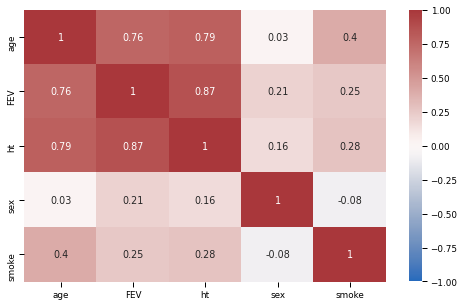

In [3]:
correlation_matrix = df.corr().round(2)
fig, ax = plt.subplots(figsize=(8.1, 5))
sns.heatmap(data=correlation_matrix, annot=True,vmin=-1,vmax=1,cmap='vlag')# annot = True to print the values inside the square

We select those features which have a high correlation with our target variable **FEV**. By looking at the correlation matrix we can see that **age** and **ht** have a strong positive correlations with **FEV** (0.76) and (0.87) respectively.

We are going to examine **FEV** (y) vs. **age** (x).

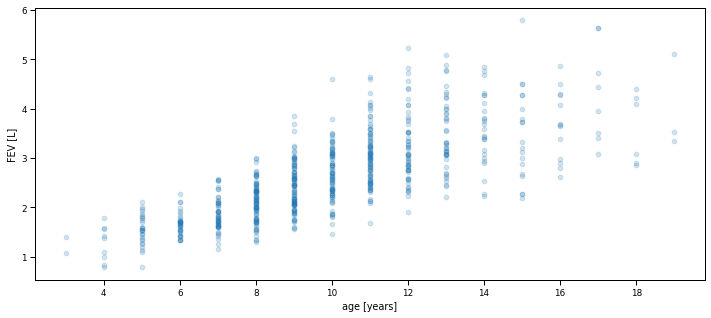

In [4]:
x = df["age"]
y = df["FEV"]
fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(x, y, alpha=0.2)
ax1.set_xlabel('age [years]')
ax1.set_ylabel('FEV [L]')
plt.show()

We can do the linear regression with the normal equation (and matrix inverse). This will give us a reference for how well gradient descent methods perform.

In [5]:
X     = np.vstack((np.ones_like(x), x)).transpose() #make X= [1,x]
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) #
err_best   = np.mean((y-X.dot(theta_best))**2)**0.5
print("Normal: slope = %3.3f, intercept = %3.3f, MSE = %3.3f"%(theta_best[1],theta_best[0],err_best))

Normal: slope = 0.222, intercept = 0.432, MSE = 0.567


### define some useful functions

In [6]:
#myPlotContours: given the axis ax, meshgrid (x,y), range of theta0,theta1, make contour plot
def myPlotContours(ax,x,y,trange0,trange1,lvls):    
    T0, T1 = np.meshgrid(np.linspace(trange0[0],trange0[1],50),np.linspace(trange1[0],trange1[1],50)) #input the range of theta0, theta1 to find the contour
    #Computing the cost function for each theta combination
    Xb     = np.vstack((np.ones(y.shape[0]), x)).transpose()   #make X= [1,x]
    # compute the MSE over the range of theta0,theta1
    zs = np.array(  [getMSE(Xb, y,np.array([t0,t1]))  for t0, t1 in zip(T0.ravel(), T1.ravel()) ] )
    Z = zs.reshape(T0.shape)
    line_c = ax.contour(T0, T1, Z,lvls,norm=LogNorm())#, norm=LogNorm())    
    ax.clabel(line_c,colors=['black'],manual=False, inline=True,rightside_up=True,  fmt=' {:.1f} '.format)
#predict: given theta and x, find y_predicted
def predict(x,theta):
    X     = np.vstack((np.ones_like(x), x)).transpose() #make X= [1,x]
    return X.dot(theta)
#get the MSE 
def getMSE(X,y,theta):
    return np.mean((y-X.dot(theta))**2)**0.5
#gradientDescent, given our x,y, starting theta0, learning rate alpha, do for Niterations
def gradientDescent(x, y, theta0, alpha, Niterations):
    N     = y.shape[0]  
    X     = np.vstack((np.ones(N), x)).transpose() #make X= [1,x]
    theta_hist=[]
    theta = theta0.copy()
    J_hist= []
    for i in range(Niterations):
        y_estimate = X.dot(theta)
        error      = (y - y_estimate)      #this is a vector of residuals  
        gradient   = -(1.0/N) * error.dot(X)        
        theta      = theta - alpha * gradient   #update theta
        err        = getMSE(X,y,theta)     #update the error
        theta_hist.append(theta)
        J_hist.append(err)
        if (err>1e20 or np.isnan(err) or np.isinf(err)): #our algorithm has diverged/crashed
            break
    theta_hist = np.array(theta_hist)
    J_hist = np.array(J_hist)
    return theta,J_hist

Lets do a SGD starting at $\theta = (1,1)$ with a learning rate $\alpha = 0.01$ for $N_{iterations}$=1000.

In [7]:
theta  = np.array([1,1])
Niterations = 100
alpha  = 0.01
(thetaGD, c) = gradientDescent(x,y,theta,alpha, Niterations)
print("GD:   slope = %3.3f, intercept = %3.3f, MSE = %3.3f"%(thetaGD[1],thetaGD[0],c[-1]))

GD:   slope = 0.180, intercept = 0.886, MSE = 0.581


Lets examine our fits (the best fit using the normal equation) and the fit using SGD.

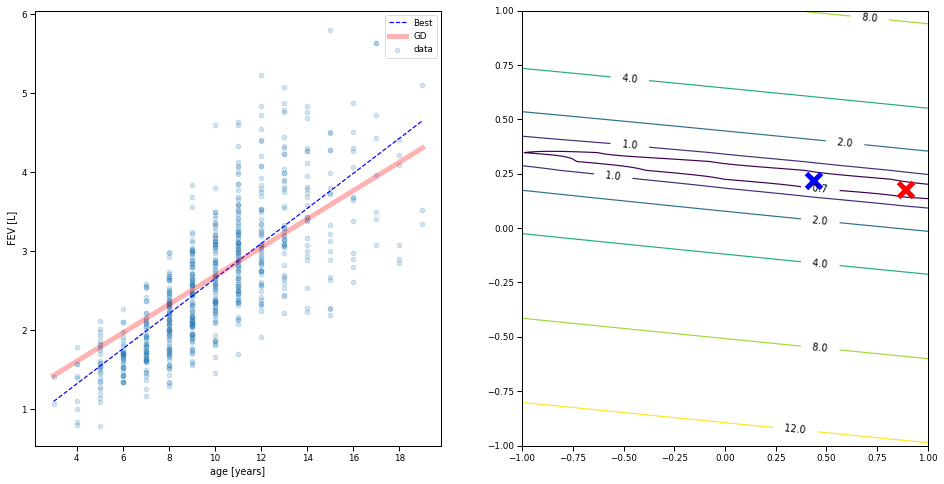

In [8]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x, y, alpha=0.2,label='data')
xp = np.linspace(np.min(x),np.max(x),10)
yp = predict(xp,thetaGD)
yb = predict(xp,theta_best)
ax1.plot(xp, yb, 'b--',label='Best')
ax1.plot(xp, yp, 'r-',label='GD',linewidth=5,alpha=0.3)
plt.legend()
ax1.set_xlabel('age [years]')
ax1.set_ylabel('FEV [L]')
###contour plot
ax = fig.add_subplot(1, 2, 2)
lvls = np.array([0.7,1,2,4,8,12])
myPlotContours(ax,x,y,(-1,1),(-1,1),lvls)
plt.plot(thetaGD[0],thetaGD[1],'rx',ms=15,mew=5,label='GD')
plt.plot(theta_best[0],theta_best[1],'bx',ms=15,mew=5,label='Best')
plt.show()

### RMS prop - Stochastic Gradient with momentum +

In [9]:
def sgdRMSprop(x, y, theta, alpha, Niterations,batchSize=None):
    gamma = 0.9
    eps   = 1e-8 #avoid divide by zero
    N     = y.shape[0]  
    if (batchSize==None or batchSize>N): batchSize = N; #handle errors
    X     = np.vstack((np.ones(N), x)).transpose()      #make X= [1,x]
    v     = np.zeros(theta.shape)
    err0  = getMSE(X,y,theta)
    theta_hist=[]
    J_hist= []
    for i in range(Niterations):
        indexs     = np.random.permutation(N)           #shuffle indices
        indj       = indexs[:batchSize]                 #get only a batchSize of indices
        y_estimate = X[indj].dot(theta)
        error      = (y[indj] - y_estimate)        
        gradient   = -(1.0/batchSize) * error.dot(X[indj])
        v          = gamma * v + (1.-gamma) * gradient**2
        theta      = theta - alpha * gradient / (eps + np.sqrt(v))
        err        = getMSE(X,y,theta)
        if (err>1e20 or np.isnan(err) or np.isinf(err)): #our algorithm has diverged/crashed
            break
        theta_hist.append(theta)
        J_hist.append(err)
    theta_hist = np.array(theta_hist)
    J_hist = np.array(J_hist)
    return theta,J_hist

In [10]:
theta  = np.array([1,1])
Niterations = 500
alpha  = 0.01
(thetaRM, c) = sgdRMSprop(x,y,theta,alpha, Niterations)
print("RMSprop: slope = %3.3f, intercept = %3.3f, MSE = %3.3f"%(thetaRM[1],thetaRM[0],c[-1]))

RMSprop: slope = 0.217, intercept = 0.426, MSE = 0.569


## Plot: compare normal with Momentum

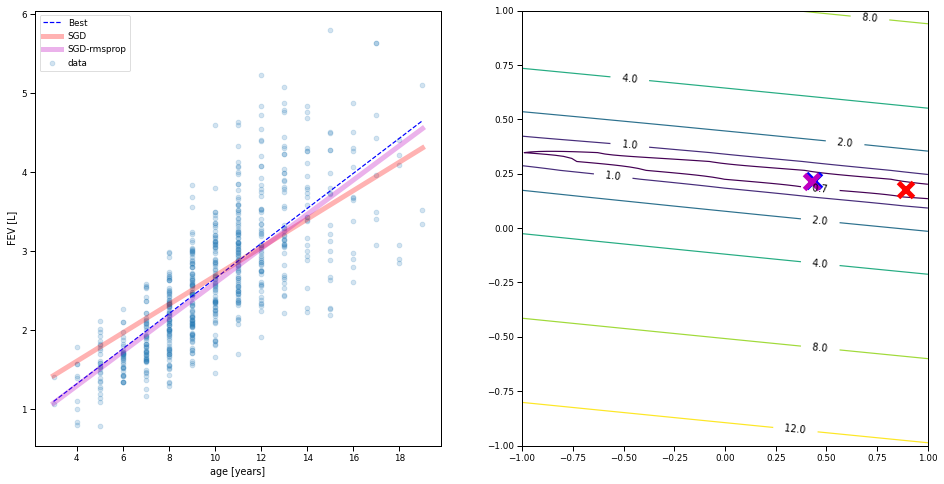

In [11]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x, y, alpha=0.2,label='data')
xp = np.linspace(np.min(x),np.max(x),10)
yg = predict(xp,thetaGD)                    #find y predicted for gradient descent
ym = predict(xp,thetaRM)                    #find y predicted for rms-prop
yb = predict(xp,theta_best)                 #find y predicted for gradient descent
ax1.plot(xp, yb, 'b--',label='Best')
ax1.plot(xp, yg, 'r-',label='SGD',linewidth=5,alpha=0.3)
ax1.plot(xp, ym, 'm-',label='SGD-rmsprop',linewidth=5,alpha=0.3)
plt.legend()
ax1.set_xlabel('age [years]')
ax1.set_ylabel('FEV [L]')
###contour plot
ax = fig.add_subplot(1, 2, 2)
lvls = np.array([0.7,1,2,4,8,12])
myPlotContours(ax,x,y,(-1,1),(-1,1),lvls)
plt.plot(thetaGD[0],thetaGD[1],'rx',ms=15,mew=5,label='GD')
plt.plot(theta_best[0],theta_best[1],'bx',ms=15,mew=5,label='Best')
plt.plot(thetaRM[0],thetaRM[1],'mx',ms=15,mew=5,label='Best')
plt.show()

## how our result depend on the learning rate

Lets use the SGDregressor to test how the stochastic gradient descent method might depend learning rate.

In [12]:
theta  = np.array([2,2]) #theta start
Niterations = 100   
alphas = np.logspace(-2,0,20)  #10^-2 .... 10^0,  split 20ways
cost_a0 = np.zeros(alphas.shape)
cost_a1 = np.zeros(alphas.shape)
# big batch size, full data
batchSize0 = y.shape[0] #=N datapoints
for i,a in enumerate(alphas):
    (thetaS, c) = sgdRMSprop(x,y,theta,a, Niterations,batchSize0)
    cost_a0[i] = c[-1]
    print(i,a,thetaS,cost_a0[i])
#change batchSize    
batchSize1 = 8
for i,a in enumerate(alphas):
    (thetaS, c) = sgdRMSprop(x,y,theta,a, Niterations,batchSize1)
    cost_a1[i] = c[-1]
    print(i,a,thetaS,cost_a1[i])

0 0.01 [0.97552045 0.97543502] 8.347606402511452
1 0.012742749857031334 [0.73312591 0.73293232] 5.611444383446213
2 0.016237767391887217 [0.47366113 0.47311537] 2.701662726845846
3 0.0206913808111479 [0.28045556 0.27826073] 0.7172162593428189
4 0.026366508987303583 [0.24795062 0.23936854] 0.569080565270926
5 0.03359818286283781 [0.26059787 0.23798545] 0.5687514652941023
6 0.04281332398719394 [0.28271602 0.23592353] 0.5682459111312955
7 0.0545559478116852 [0.31446161 0.23296426] 0.5676418612376612
8 0.06951927961775606 [0.35224984 0.22944171] 0.5671101760986432
9 0.08858667904100823 [0.3547064  0.20544795] 0.6180082968814316
10 0.11288378916846889 [0.38051294 0.22396896] 0.5675892597335431
11 0.14384498882876628 [0.26128037 0.09499632] 1.585104181371384
12 0.18329807108324356 [0.36003567 0.19075176] 0.6898002162116799
13 0.23357214690901212 [0.24395199 0.07259149] 1.8196071445770674
14 0.29763514416313175 [0.29003437 0.11804215] 1.3396479649790483
15 0.37926901907322497 [0.21301575 0.04

Plot our results

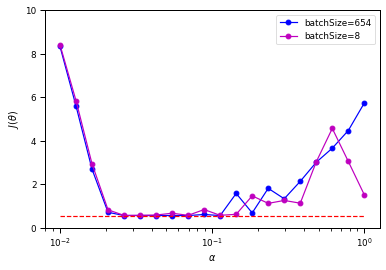

In [13]:
plt.plot(alphas,cost_a0,'bo-',label='batchSize=%d'%batchSize0)
plt.plot(alphas,cost_a1,'mo-',label='batchSize=%d'%batchSize1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$J(\theta)$')
plt.xscale('log')
plt.plot(alphas,err_best*np.ones(alphas.shape),'r--')
plt.ylim([0,10])
plt.legend()
plt.show()

We found was the range for learning rates for which our SGD converges (within the Niterations).

* If $\alpha$ is too small, then $\theta$ does not evolve enough to significantly decrease the loss function $J(\theta)$
* If $\alpha$ is too large, then $\theta$ diverges and things spin out of control quickly.